많은 경우 머신러닝 훈련 샘플은 수천 혹은 수백만개의 특성을 가지고 있다. 특성을 줄여 훈련을 빠르게 하고, 좋은 솔루션을 찾을 수 있게 할 필요가 있다. 이를 차원 축소라 한다. 차원 축소는 데이터 시각화에도 유용하다.

Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

간단한 3D 데이터셋을 만들어보자

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

In [12]:
X3D_inv = pca.inverse_transform(X2D)

In [13]:
np.allclose(X3D_inv, X)

False

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

차원 축소를 위한 방법

투영: 샘플은 모든 차원에 균일하게 퍼져 있지 않다. 많은 특성은 거의 변화가 없지만 다른 특성들은 서로 강하게 연관되어 있다. 이로 인해 모든 훈련 샘플은 그들을 담는 고차원 공간 안의 어떤 저차원의 부분집합에 포섭된다. 여기서 모든 훈련 샘플을 이 부분 공간에 수직으로 투영하면 차원을 줄일 수 있다.

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

C:\Users\82102\AppData\Local\Temp\ipykernel_20688\572184495.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")


(-1.0, 1.0)

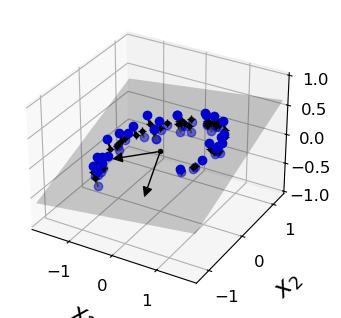

In [24]:
from mpl_toolkits.mplot3d import Axes3D

### AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection' 오류를 해결하기 위해 추가한 블럭
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)
### 이 블럭 없이 작동한다면 빼도 됨. matplotlib 3.5.0부터 오류가 있다고 함.

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

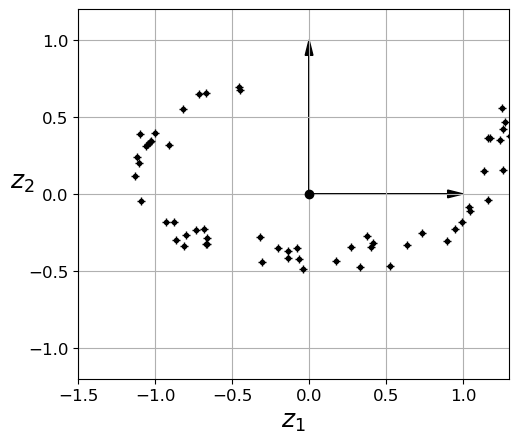

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

매니폴드: 만약 데이터가 어떤 부분공간에 수직으로 투영할 시 뭉개지는 형태로 고차원에 존재한다면(뒤틀리거나 휘어 있다면)(예를 들면 3차원상에서 롤케이크처럼 말려 있다면 어떤 2차원 평면으로도 데이터를 뭉개지지 않게 투영시킬 수 없다.) 이를 매니폴드라 한다. 일반적으로 d차원 매니폴드는 n차원(d < n) 공간의 일부로서 국부적으로 d차원 초평면으로 보일 수 있다. 많은 차원 축소 알고리즘이 훈련 샘플이 놓여있는 매니폴드를 모델링하는 식으로 작동한다. 이를 매니폴드 학습이라 한다. 이는 고차원 데이터셋이 저차원 매니폴드에 가깝게 놓여있다는 매니폴드 가정에 근거한다.

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

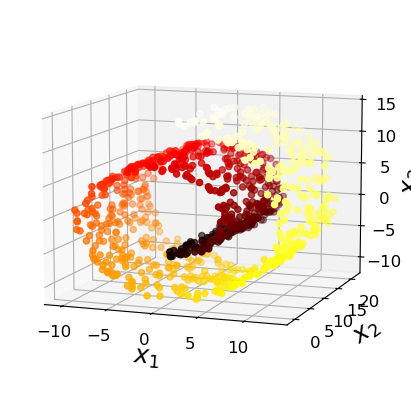

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

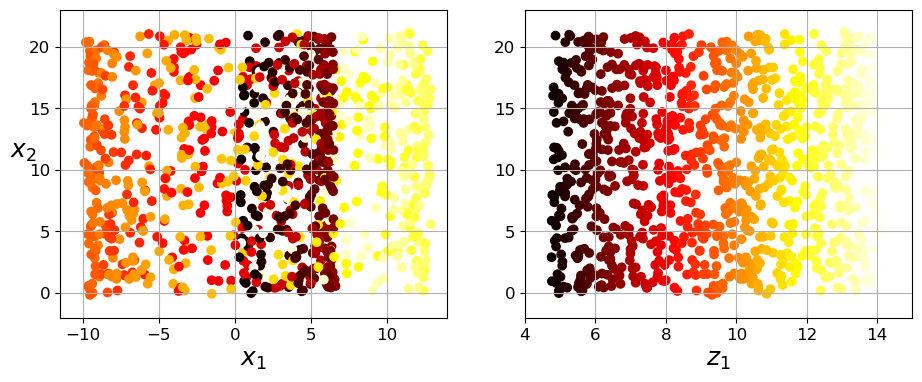

In [28]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

매니폴드 가정은 다른 가정과 병행되곤 한다. 바로 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이란 가정이다. 이는 항상 유효한 가정은 아니다. 저차원으로 샘플링된 매니폴드가 오히려 더 복잡한 결졍 경계를 가질 수 있다.

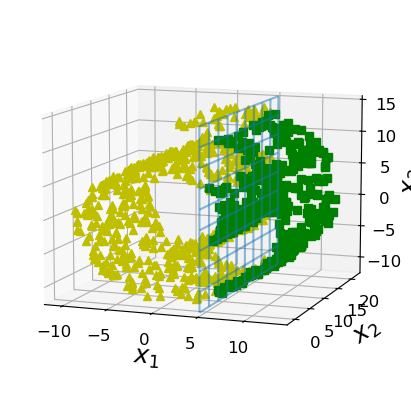

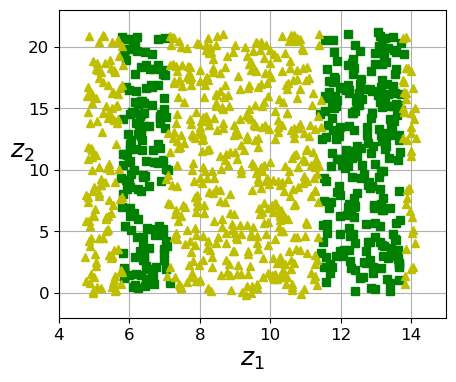

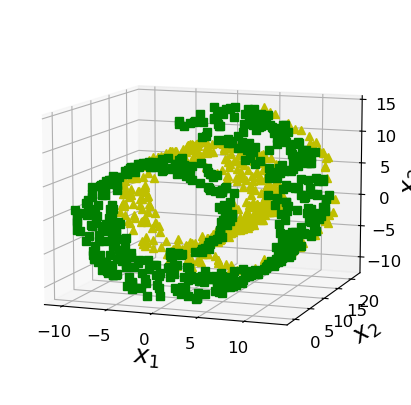

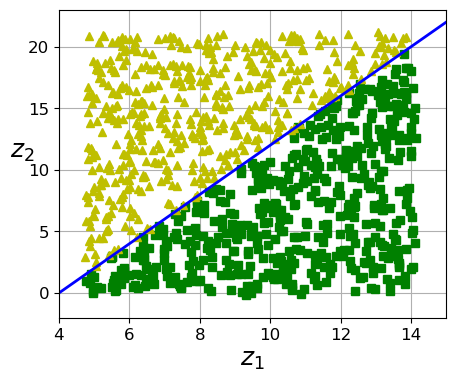

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

차원 축소 알고리즘

PCA(주경계 분석)은 가장 인기 있는 차원 축소 알고리즘이다. 데이터에 가장 가까운 초평면을 정의한 다음 데이터를 이 평면에 투영시킨다.

먼저 올바른 저차원 초평면을 선택해야 한다. 다음은 2D 데이터셋을 세 방향의 1차원 선에 투영시킨 결과이다. 실선에 투영시켰을 때 분산이 최대한 보존된다. 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적이다. 이 방식은 원본 데이터셋과 투영된 데이터셋 사이의 평균 제곱 거리를 최소화하는 축을 선택함으로 구현할 수 있다(분산이 최대인 축을 선택한다).

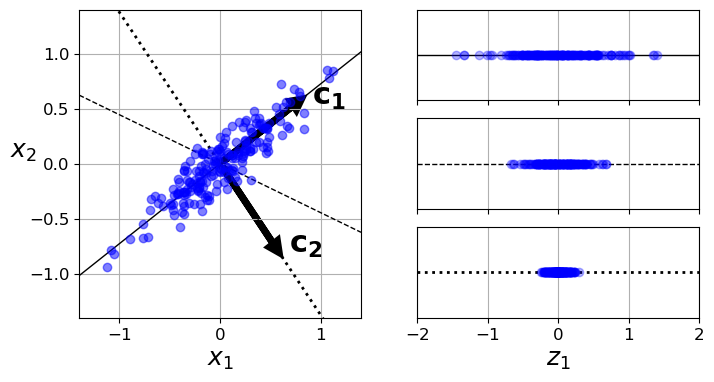

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

PCA는 훈련 세트에서 분산이 최대인 축을 찾는다. 최초로 찾은 축에 직교하고, 남은 분산을 최대한 보존하는 축을 두 번째 축으로 설정한다. 이를 반복하며 차원을 이루는 모든 기저 축을 찾는다. i번째 축을 데이터의 i번째 주성분이라 한다. 훈련 세트의 주성분은 특잇값 분해(SVD)라는 표준 행렬 분해 기술로 훈련 세트를 행렬곱으로 분해하여 찾을 수 있다. 다음은 주성분을 구하는 넘파이 함수 svd()로 처음 두 개의 주성분을 정의하는 두 개의 단위 벡터를 추출한 것이다.

In [31]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

주성분을 모두 추출했다면 d개의 주성분으로 정의한 초평면에 데이터셋을 투영하여 d차원으로 축소시킬 수 있다. 다음은 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영하는 코드이다.

In [32]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [33]:
X2D_using_svd = X2D

사이킷런의 PCA 모델은 SVD 분해 방법을 사용하여 구현한다. 다음은 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드이다. 사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰준다.

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

여기서 explained_variance_ratio_ 변수에 저장된 주성분의 설명된 분산의 비율은 유용한 정보이다. 이 비율은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다.

In [35]:
pca.explained_variance_ratio_

array([0.95369864, 0.04630136])

이는 데이터셋 분산의 95%가 첫 번째 주성분을 따라 놓여 있고 4.6%가 두 번째 주성분을 따라 놓여 있음을 알려준다. 이 퍼센티지가 적을수록 정보의 양이 적다는 뜻이다.

적절한 차원 수를 선택하는 방법은 간단하다. 물론 데이터 시각화를 위한 차원 축소의 경우 2 혹은 3차원으로 줄이는 것이 일반적이다. 다음 코드는 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산한다(분산은 주성분을 순서대로 더할수록 많이 확보되지만, 주성분이 많을수록 차원을 조금밖에 못 줄이게 되는 trade-off 관계가 있다.).

In [36]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

C:\Users\82102\anaconda3\envs\MLpy310\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [37]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [39]:
d

154

혹은

In [40]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [41]:
pca.n_components_

154

아래는 분산을 차원 수에 대한 함수로 나타낸 것이다(cumsum을 그래프로 그린 것). 분산의 빠른 성장이 멈추는 변곡점을 elbow라 한다. 이 점 언저리 까지는 차원을 축소해도 분산을 크게 손해보진 않을 수 있다.

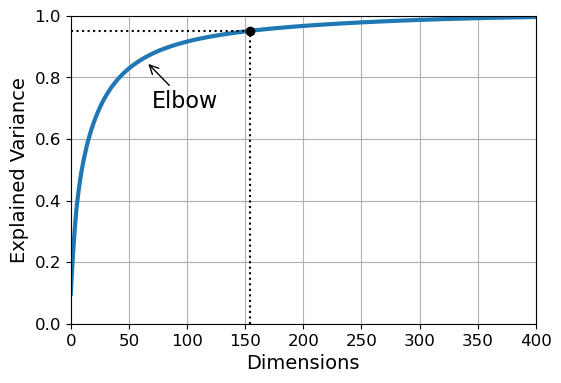

In [42]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

MNIST 데이터셋의 분산을 95% 유지하며 PCA를 적용해보면 784개 특성이 150개 정도로 줄어들고, 데이터셋의 크기는 원본의 20% 미만이 된다. 이렇게 압축된 데이터셋은 분류 알고리즘의 속도를 크게 높일 수 있다.

압축된 데이터셋에 PCA 투영 변환을 반대로 적용해 차원을 되돌릴 수도 있다. 물론, 투영에서 일정량의 정보(위에선 5%의 분산)를 잃어버렸기 때문에 원본 데이터를 얻을 수는 없다. 원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리를 재구성 오차라 한다. 다음은 MNIST의 원본과 재구성 데이터셋을 비교한 것이다.

In [43]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [44]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

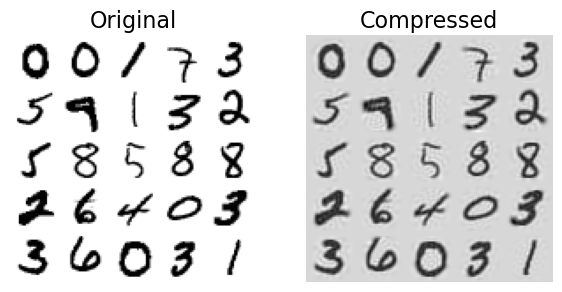

In [45]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

PCA에섯 svd_solver 매개변수를 "randomized"로 지정하면 사이킷런은 랜덤PCA라 불리는 확률적 알고리즘을 사용해 처음 d개의 주성분에 대한 근삿값을 빠르게 찾는다. 이 방식은 완전SVD보다 빠르다. 기본값은 "auto"이므로 완전SVD 방식을 강제하려면 "full"을 사용하면 된다.

In [46]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것이다. 다행히 점진적 PCA(IPCA) 알고리즘이 개발되았다. 다음 코드는 MNIST를 100개의 미니 매치로 나누고 IPCA를 실행하는 코드이다.

In [47]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

다음은 위 방법으로 차원을 줄인 데이터셋을 복원한 모습이다.

In [48]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

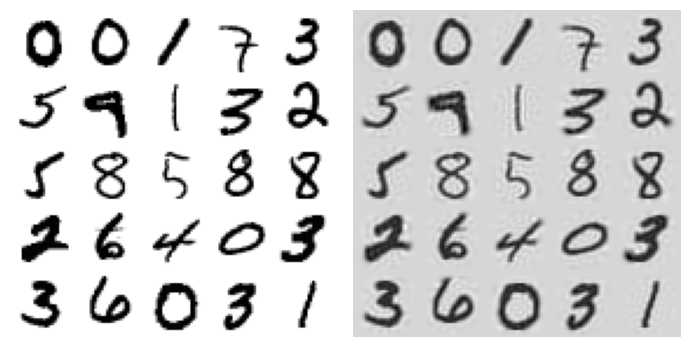

In [49]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

위 방법은 전체 데이터셋을 나눠 훈련시키기 때문에 fit() 매서드가 아닌 partial_fit() 메서드를 미니배치마다 호출해야 한다. 넘파이의 memmap 클래스를 사용하면 하드디스크상의 파일을 메모리에 올려놓은 것처럼 다룰 수 있기 때문에 fit() 메서드를 사용할 수 있다.

In [50]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [51]:
del X_mm

In [52]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

커널 트릭(샘플을 매우 높은 고차원 공간으로 암물적으로 매핑하여 SVM의 비선형 분류와 회귀를 가능하게 하는 수학적 기법. 고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 복잡한 비선형 결정 경계에 해당)을 PCA에 적용해 차원 축소를 위한 복잡한 비선형 투영을 수행할 수 있다. 이를 커널PCA라 한다. 이 기법은 투영 후 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용하다. 아래는 사이킷런의 rbf커널로 kPCA를 적용한 코드와 선형 커널, RBF커널, 시그모이드 커널의 사용 결과를 비교하는 코드이다.

In [53]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [54]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

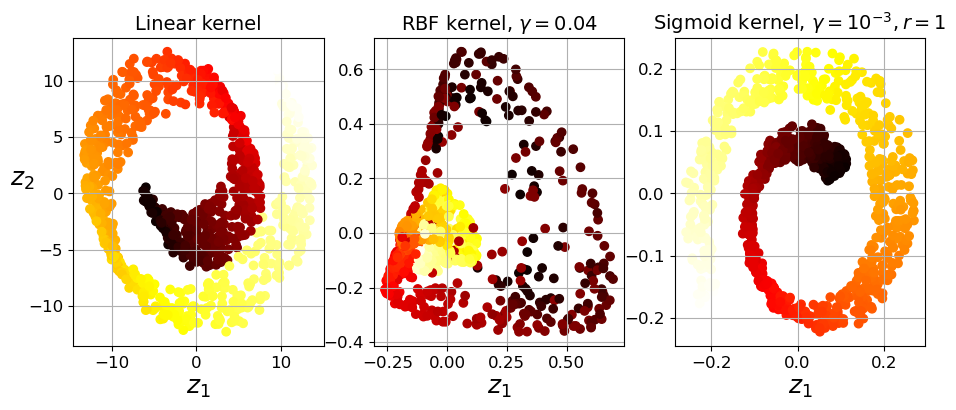

In [55]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

kPCA는 비지도학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 성능 측정 기준이 없다. 하지만 차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용해 좋은 커널과 하이퍼파라미터를 선택할 수 있다. 다음은 kPCA를 사용해 차원을 축소하고 분류를 위해 로지스틱 회귀를 적용한 후, GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾는 코드이다.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [57]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


반면 완전 비지도 학습 방법으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있다. RBF커널의 kPCA를 적용한 변환은 커널 트릭 덕분에 특성 맵 에타를 사용하여 훈련 세트를 무한 차원 특성 공간에 매필한 다음, 변환된 데이터셋을 선형 PCA를 사용해 투영항 것과 수학적으로 동일하다. 축소된 공간에 있는 샘플에 대해 선형 PCA를 역전시키면 재구성된 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓이게 된다. 이 특성 공간은 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 재구성에 따른 실제 에러를 계산할 수 없다. 다행히 재구성된 포인에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있다. 이를 재구성 원상이라 부른다.

원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정할 수 있다. 이로써 재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터를 선택할 수 있다.

재구성 방법중 하나는 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련시키는 것이다. fit_inverse_transform=True로 설정하면 이를 자동으로 수행한다.

In [58]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

재구성 원상 오차는 다음과 같이 계산할 수 있다. 이후 교차 검증으로 그리드 탐색을 사용할 수 있다.

In [59]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576608

LEE

LEE는 지역 선형 임베딩이다. 강력한 비선형 차원 축소 기술이다. 투영에 의존하지 않는 매니폴드 학습이다. 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어 있는지 측정하여 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾는다. 이 방법은 잡음이 많지 않은 경우 꼬인 매니폴드를 펼치는 데 잘 작동한다. 다만 대량의 데이터셋에는 적용하기 어렵다.

In [61]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [62]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

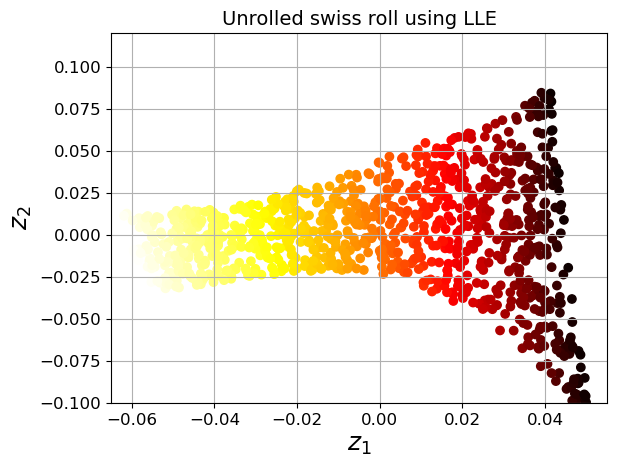

In [63]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

다른 차원 축소 기법을 소개한다.

랜덤 투영: 랜덤한 선형 투영을 사용해 데이터를 저차원 공간으로 투영한다. 랜덤 투영은 거리를 잘 보존하는 것이 수학적으로 증명되었다.

다차원 스케일링(MDS): 샘플간의 거리를 보존하면서 차원을 축소한다.

Isomap: 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만든다. 그 다음 샘플 간의 지오데식 거리를 유지하면서 차원을 축소한다.

t-SNE: 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소한다. 주로 시각화에 많이 사용된다.

선형 판별 분석(LDA): 분류 알고리즘이다. 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습하는데, 이 축이 데이터가 투영될 초평면을 정의하는 데 사용될 수 있다. 이 방법은 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시킬 때 좋다.

In [64]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

C:\Users\82102\anaconda3\envs\MLpy310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [65]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

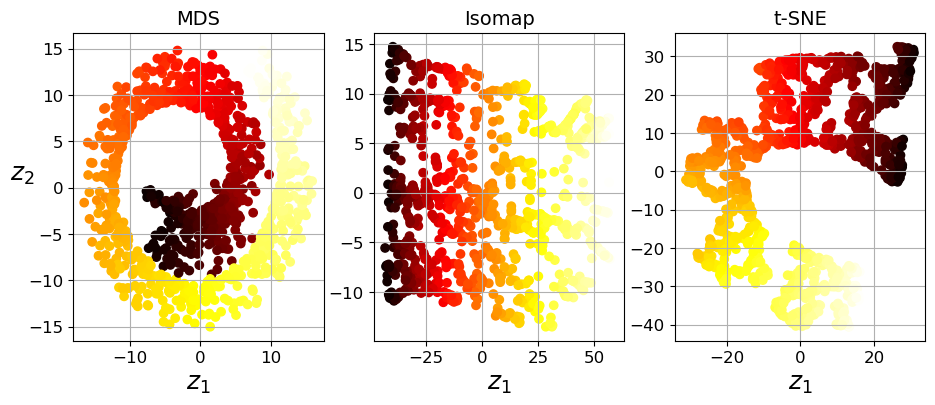

In [69]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()